# TP4 : Reconnaissance de mots isolés par programmation dynamique (DTW)

NOM - PRÉNOM : LABORIE RÉMI
Déposer le notebook sur moodle à la fin de la séance.

In [46]:
import numpy as np
from math import floor, inf, dist
import scipy.io.wavfile as wav
import os
import matplotlib.pyplot as plt

# Réutilisation de fonctions pour la lecture et la paramétrisation

In [47]:
# Réutiliser la fonction lecture permettant de lire un fichier son et de connaître ses caractéristiques 
# (fréquence d’échantillonnage, durée).

# LECTURE d'un fichier Wave
def lecture(fichier, nb_bits):
    (f_ech, signal) = wav.read(fichier)
    return signal/(2**nb_bits-1), f_ech, len(signal)/f_ech

In [48]:
# Réutiliser la fonction parametrisation qui calcule les paramètres acoustiques
# (coefficients cepstraux) d’un fichier sonore sur des fenêtres de taille "taille_fenetre" avec un
# recouvrement de moitié.

# Calcul de "nbe_coef" coefficients cepstraux
def parametrisation(signal, taille_fenetre, nbe_coef):
    # Initialisation de la matrice résultat
    recouvrement = floor(taille_fenetre / 2)
    nb_fen = floor((np.size(signal) - taille_fenetre) / recouvrement) + 1
    mfcc = np.zeros((nb_fen, nbe_coef))

    # Calcul des MFCC
    for fen in range(nb_fen):
        p = fen * recouvrement
        spectre = abs(np.fft.fft(np.multiply(signal[p:p + taille_fenetre], np.hamming(taille_fenetre))))
        cepstre = np.fft.fft(np.log(spectre))
        cc = cepstre[1:nbe_coef+1].real
        mfcc[fen, :] = cc

    return mfcc

In [49]:
# Modifier votre fonction parametrisation_total (utilisant la fonction parametrisation)
# afin qu’elle permette de calculer les paramètres pour l’ensemble des fichiers d’un répertoire
# rep_wav et de stocker les résultats dans un répertoire rep_mfcc. Cette fonction renvoie
# la liste des noms de fichiers traités.
    
# Fonction de paramétrisation totale --> tous les fichiers du répertoire 'WAV/APP'

def parametrisation_total(nb_bits, taille_fenetre, nbe_coef, rep_wav, rep_mfcc):

    nom_fichiers_wav = os.listdir(rep_wav)

    for i, fichier_wav in enumerate([rep_wav + "/" + nom for nom in nom_fichiers_wav]):
            fichier_mfcc = rep_mfcc + "/" + nom_fichiers_wav[i].split(".")[0] + '.mfcc'

            signal, fe, duree = lecture(fichier_wav, nb_bits)

            p = parametrisation(signal, taille_fenetre, nbe_coef)
            np.savetxt(fichier_mfcc, p, fmt='%f')

# Programmation dynamique

In [50]:
# Ecrire une fonction dtw qui prend deux arguments en entrée : la matrice de coefficients
# cepstraux du signal à reconnaître (observation) et la matrice de coefficients cepstraux d'un
# signal de référence. Cette fonction renvoie le coût normalisé.
    
# Calcul de la DTW entre deux vecteurs
def d_gen(mfcc_ref, mfcc_obs):
    def d(i, j):
        return dist(mfcc_obs[i - 1], mfcc_ref[j - 1])
    return d

def dtw(mfcc_ref, mfcc_obs):

    d = d_gen(mfcc_ref, mfcc_obs)

    wg = 1
    wd = 2
    wh = 2

    N = mfcc_obs.shape[0]
    M = mfcc_ref.shape[0]

    g = np.empty((N + 1, M + 1))
    g[0, 0] = 0

    for i in range(1, N + 1):
        g[i, 0] = inf
    for j in range(1, M + 1):
        g[0, j] = inf

    for i in range(1, N + 1):
        for j in range(1, M + 1):
            distance = d(i, j)

            gg = g[i - 1,  j] + wg * distance
            gd = g[i - 1, j - 1] + wd * distance
            gh = g[i, j - 1] + wh * distance

            g[i, j] = min(gg, gd, gh)
    return g[N, M] / (N + M)

In [51]:
#Ecrire une fonction dtw_total (utilisant la fonction dtw) qui calcule la DTW sur toutes
# les observations (fichiers Wave) du répertoire rep_obs par rapport à toutes les références
# (fichiers MFCC) du répertoire rep_ref. Cette fonction renvoie une matrice de coûts de taille
# nb_fichier_obs x nb_fichier_ref.

# DTW sur toutes les observations par rapport à toutes les références
def DTW_total(nb_bits, taille_fenetre, nbe_coef, rep_mfcc_ref, rep_wave_obs):

    nom_fichiers_wave_obs = os.listdir(rep_wave_obs)
    nom_fichiers_mfcc_ref = os.listdir(rep_mfcc_ref)

    res_numpy = np.empty((len(nom_fichiers_wave_obs), len(nom_fichiers_mfcc_ref)))
    res_dict = {}

    for i, fichier_wav in enumerate((rep_wave_obs + "/" + nom for nom in nom_fichiers_wave_obs)):
        signal, fe, duree = lecture(fichier_wav, nb_bits)
        mfcc_obs = parametrisation(signal, taille_fenetre, nbe_coef)
        res_dict[nom_fichiers_wave_obs[i].split(".")[0]] = {}

        for j, fichier_mfcc in enumerate((rep_mfcc_ref + "/" + nom for nom in nom_fichiers_mfcc_ref)):
            mfcc_ref = np.loadtxt(fichier_mfcc)
            #print(fichier_mfcc, fichier_wav, dtw(mfcc_ref, mfcc_obs))
            res_numpy[i, j] = dtw(mfcc_ref, mfcc_obs)
            res_dict[nom_fichiers_wave_obs[i].split(".")[0]][nom_fichiers_mfcc_ref[j].split(".")[0]] = dtw(mfcc_ref, mfcc_obs)

    return res_numpy, res_dict


# Affichages et tests

In [52]:
# Ecrire un programme principal qui lance les fonctions précédentes et affiche pour chaque
# observation (mot inconnu), le mot le plus probable.

# Initialisation
q = 16
taille_fenetre = 1024
nbe_coef = 16
rep_ref = 'SIGNAL/REF'
rep_obs = 'SIGNAL/OBS'
rep_mfcc = 'MFCC'

In [53]:
# Paramétrisation des fichiers références
parametrisation_total(q, taille_fenetre, nbe_coef, rep_ref, rep_mfcc)

# Test de la DTW

In [54]:
# DTW sur toutes les observations par rapport à chaque référence
couts_numpy, couts_dict = DTW_total(q, taille_fenetre, nbe_coef, rep_mfcc, rep_obs)

# Affichage des couts
print(couts_dict)

{'alpha': {'alpha': 341.5087021125876, 'bravo': 525.9596372441374, 'charlie': 687.9439401435047, 'delta': 390.3975726641194, 'echo': 503.34945011881865, 'foxtrott': 483.05239699211, 'golf': 510.43018192891265, 'hotel': 493.1471207935471, 'india': 477.87339898955474, 'juliett': 578.8327683520536, 'kilo': 545.110483876864, 'lima': 458.3781654806293, 'mike': 495.34359085621406}, 'bravo': {'alpha': 465.0215316145683, 'bravo': 340.1833617143324, 'charlie': 666.0092455016426, 'delta': 464.4153057161259, 'echo': 463.6221365473196, 'foxtrott': 522.1408791232526, 'golf': 440.0656242203821, 'hotel': 480.7683261260159, 'india': 459.22572695944444, 'juliett': 531.8226025719237, 'kilo': 513.5415435828221, 'lima': 504.2348207845217, 'mike': 482.60812228251086}, 'charlie': {'alpha': 550.3636985153928, 'bravo': 631.7726173013848, 'charlie': 474.71598209740074, 'delta': 552.3378651515249, 'echo': 642.718088167399, 'foxtrott': 655.0766842874849, 'golf': 557.2079448195709, 'hotel': 606.9543723412183, 'in

In [55]:
print(np.mean(couts_numpy))
print(couts_numpy)


534.5530430515602
[[341.50870211 525.95963724 687.94394014 390.39757266 503.34945012
  483.05239699 510.43018193 493.14712079 477.87339899 578.83276835
  545.11048388 458.37816548 495.34359086]
 [465.02153161 340.18336171 666.0092455  464.41530572 463.62213655
  522.14087912 440.06562422 480.76832613 459.22572696 531.82260257
  513.54154358 504.23482078 482.60812228]
 [550.36369852 631.7726173  474.7159821  552.33786515 642.71808817
  655.07668429 557.20794482 606.95437234 556.49098613 587.85231603
  475.86484038 544.30728133 479.77658587]
 [407.88719539 485.36558666 708.56695237 332.99562093 489.89490186
  562.14827861 476.75869368 486.51660053 393.23068663 504.34635311
  529.447774   395.70176262 471.16018624]
 [549.8935781  527.76937919 778.23018586 548.59904376 317.66771167
  646.86452657 545.23321602 636.01120757 497.01490829 564.42567391
  511.47516375 531.86729887 623.4081287 ]
 [621.97094739 693.91689892 754.59579836 579.28341647 733.82621586
  523.62538182 684.11529307 691.453

In [56]:
print(couts_dict["bravo"]["bravo"])

340.1833617143324


100.0


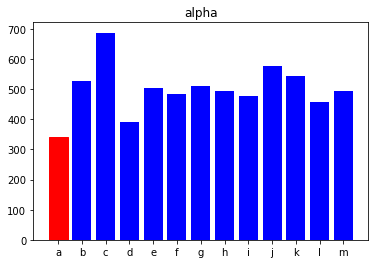

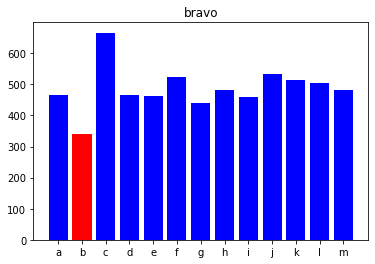

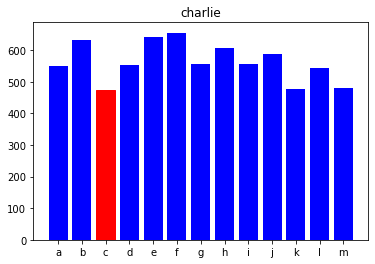

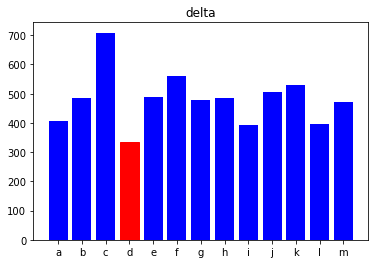

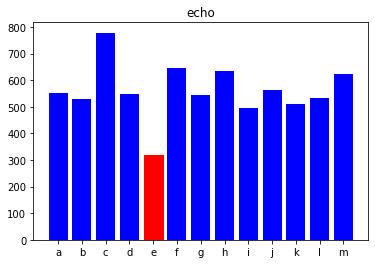

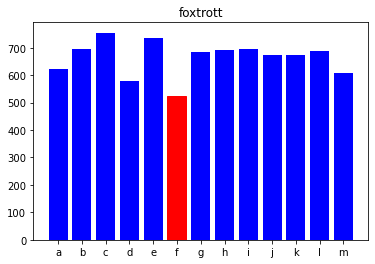

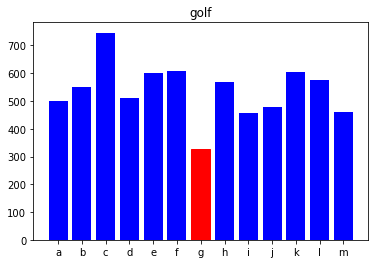

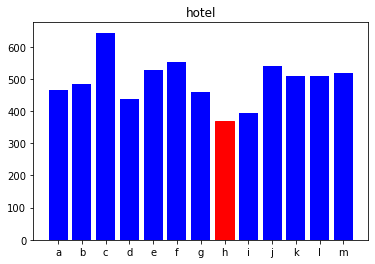

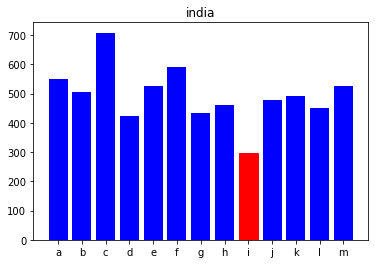

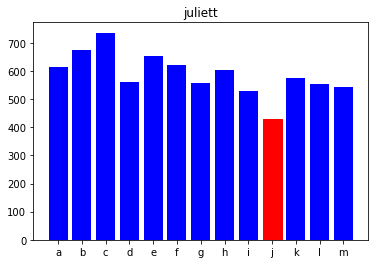

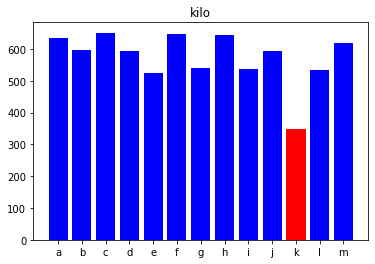

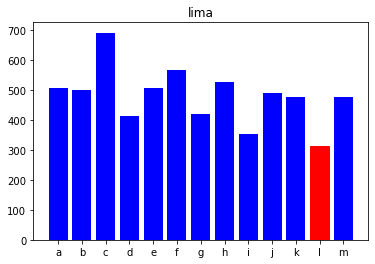

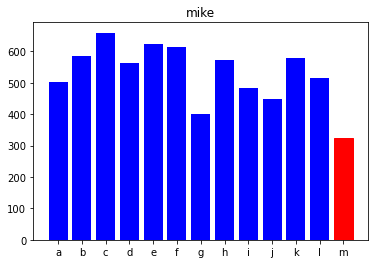

In [57]:
# Affichage amélioré

def getScore(couts:dict):
    score = 0
    for cout in couts:
        if cout == min(couts_dict[cout], key=couts_dict[cout].get):
            score += 1
    return score / len(couts) * 100

def afficher_dtw(obs, couts:dict):

    x = []
    y = []

    for ref, cout in couts.items():
        x.append(ref[0])
        y.append(cout)

    plt.figure()
    plt.title(obs)
    plt.bar(x, y, color='blue')[np.argmin(y)].set_color('red')


    plt.show()

def afficher_dtw_all(coutss:dict):
    for obs, couts in coutss.items():
        afficher_dtw(obs, couts)

# Ajouter à votre programme principal, un affichage des coûts entre une observation et chaque
# référence sous forme d'histogramme via la commande bar.
# Calculer le score de reconnaissance.

# Pour chaque observation, affichage des coûts (par rapport aux références) sous forme d'histogramme

print(getScore(couts_dict))
afficher_dtw_all(couts_dict)

In [58]:
# Affichage score final


In [59]:
# Autres tests 
# Tests
# Bien  videmment, afin d’am liorer les r sultats, vous pourrez modifier :
# - le nombre de param tres (coefficients cepstraux) : nbe_coef,
# - la taille de la fen tre d’analyse : taille_fenetre,
# ET TESTER AVEC VOS PROPRES ENREGISTREMENTS !

{'./test2.wav': {'alpha': 612.5630654740855, 'bravo': 675.6967924453533, 'charlie': 735.7525325335002, 'delta': 560.2581987883077, 'echo': 653.1745807747375, 'foxtrott': 621.9338863496808, 'golf': 555.8267812590041, 'hotel': 601.5251020665758, 'india': 530.3500891830118, 'juliett': 429.06362575773227, 'kilo': 575.2202846802471, 'lima': 552.7406071647838, 'mike': 543.5475913150489}}
429.06362575773227


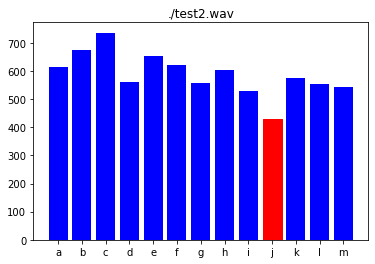

In [60]:


signal, fe, duree = lecture("./test2.wav", q)
mfcc_obs = parametrisation(signal, taille_fenetre, nbe_coef)

nom_fichiers_mfcc_ref = os.listdir(rep_mfcc)

res_numpy = np.empty((1, len(nom_fichiers_mfcc_ref)))
res_dict = {}

res_dict["./test2.wav"] = {}
for j, fichier_mfcc in enumerate((rep_mfcc + "/" + nom for nom in nom_fichiers_mfcc_ref)):
    mfcc_ref = np.loadtxt(fichier_mfcc)
    #print(fichier_mfcc, fichier_wav, dtw(mfcc_ref, mfcc_obs))
    res_numpy[0, j] = dtw(mfcc_ref, mfcc_obs)
    res_dict["./test2.wav"][nom_fichiers_mfcc_ref[j].split(".")[0]] = dtw(mfcc_ref, mfcc_obs)

print(res_dict)
print(min(min(res_numpy)))
afficher_dtw_all(res_dict)